### MountainCar-v0

Description:
    The agent (a car) is started at the bottom of a valley. For any given
    state the agent may choose to accelerate to the left, right or cease
    any acceleration.

Source:
    The environment appeared first in Andrew Moore's PhD Thesis (1990).

Observation:
    Type: Box(2)
    Num    Observation               Min            Max
    0      Car Position              -1.2           0.6
    1      Car Velocity              -0.07          0.07

Actions:
    Type: Discrete(3)
    Num    Action
    0      Accelerate to the Left
    1      Don't accelerate
    2      Accelerate to the Right

    Note: This does not affect the amount of velocity affected by the
    gravitational pull acting on the car.

Reward:
     Reward of 0 is awarded if the agent reached the flag (position = 0.5)
     on top of the mountain.
     Reward of -1 is awarded if the position of the agent is less than 0.5.

Starting State:
     The position of the car is assigned a uniform random value in
     [-0.6 , -0.4].
     The starting velocity of the car is always assigned to 0.

Episode Termination:
     The car position is more than 0.5
     Episode length is greater than 200

In [134]:
import numpy as np
import gym
import time
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
from thompson_sampling.bernoulli import BernoulliExperiment

Инициализация среды (поля)

In [135]:
env = gym.make('MountainCar-v0')

In [136]:
# Описание среды
# ?env.env

### Дискретизация среды

In [137]:
print ("Нижняя граница", env.observation_space.low)
print ("Верхняя граница", env.observation_space.high)

Нижняя граница [-1.2  -0.07]
Верхняя граница [0.6  0.07]


In [138]:
n_bins = (10, 10)
def discretizer(position, velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([env.observation_space.low, env.observation_space.high])
    return tuple(map(int,est.transform([[position, velocity]])[0]))

In [139]:
# print (discretizer(-1, -0.01))

### Q-обучение

In [140]:
# Создадим Q-таблицу из дискретных состояний среды и возможных действий
q_table = np.zeros(n_bins + (env.action_space.n,))
q_table.shape

(10, 10, 3)

In [141]:
# e-жадная стратегия и обновление таблицы

def policy (state, env, eps):
    if np.random.random() < eps: 
        action = env.action_space.sample() # explore
    else:
        action = np.argmax(q_table[state])
    return action

def policy_update (current_state, new_state, reward, action, lr):
    q_table[current_state][action] = (1-lr)*q_table[current_state][action] + lr*(reward + np.max(q_table[new_state]))

### Тестирование и визуализация

In [142]:
progress = []
success = 0
avg_progress = []
eps = 0.2
lr = 0.9
n_episodes = 2000
for e in range(n_episodes):
    _ = 0
    current_state, done = discretizer(*env.reset()), False
    while done==False:
        _ += 1
        action = policy(current_state, env, eps)
        obs, reward, done, info = env.step(action)
        new_state = discretizer(*obs)
        policy_update(current_state, new_state, reward, action, lr)
        current_state = new_state
        lr *= 0.9999
        eps *= 0.9999   
    progress.append(_)
    avg_progress.append(np.mean(progress))
    if e % 100 == 0:
        print(e)
    if obs[0] >= 0.5:
        success += 1
print('Success episods:', round(success / n_episodes, 2))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Success episods: 0.49


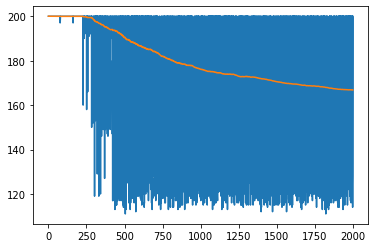

In [143]:
plt.plot(progress)
plt.plot(avg_progress)
plt.show()

### Проверка обученного агента

In [144]:
eps = 0
_ = 0
current_state, done = discretizer(*env.reset()), False
while done==False:
    _ += 1
    action = policy(current_state, env, eps)
    obs, reward, done, info = env.step(action)
    new_state = discretizer(*obs)
    current_state = new_state
    env.render()
    time.sleep(0.05)
env.close()
print (_)

122
